# Concentration vs. Extraction Time

In [1]:
import csv
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from datetime import datetime

In [2]:
ps = pd.read_csv("patch_seq_log_mouse.csv")

In [3]:
initial =["Date", "Post patch?", "Post patch pipette R", "PCR cycles", "Time spent extracting cytosol", 
          "patch duration", ">400", "SM_QC_PF", "Bad dates"]
ps = ps[initial]

##Changing Date Format
ps["Date"] = pd.to_datetime(ps["Date"], format = "%y%m%d")

#Changing String to Numerical
ps["Time spent extracting cytosol"] = pd.to_numeric(ps["Time spent extracting cytosol"].str.replace(' ',''), errors ='coerce')
ps["patch duration"] = pd.to_numeric(ps["patch duration"].str.replace(' ',''), errors ='force')
ps[">400"] = pd.to_numeric(ps[">400"].str.replace(' ',''), errors ='force')

#Categories
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")

#Filtering Columns
ps = ps[ps["PCR cycles"] == 21]      #shows 21 pcr cycles
ps = ps[ps["SM_QC_PF"] != "cnt"]     #shows everything except cnt
ps = ps[ps["Bad dates"] != "x"]      #shows everthing except x
ps = ps[ps[">400"] < 8000]
ps = ps[ps['Time spent extracting cytosol'] <= 10]

#Dropping blank columns
ps = ps.drop("Bad dates", 1)
ps.dropna(subset = ["Post patch?", "Time spent extracting cytosol", "patch duration", "SM_QC_PF"], inplace = True)
ps.head()

,Date,Post patch?,Post patch pipette R,PCR cycles,Time spent extracting cytosol,patch duration,>400,SM_QC_PF
4968,2017-04-19,Outside-Out,NaN,21.0,1.800000,4.333333,8.0,fail
4969,2017-04-19,Outside-Out,NaN,21.0,1.666667,6.566667,461.0,pass
4970,2017-04-19,No-Seal,NaN,21.0,1.433333,8.033333,1.0,fail
4971,2017-04-19,Nucleated,NaN,21.0,2.350000,7.416667,979.0,pass
4972,2017-04-19,Outside-Out,NaN,21.0,2.216667,4.166667,456.0,pass


## Definitions

In [4]:
def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 500))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 499))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 500))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 499))]
    return no
    
def entire_cell(v):
    entire = v[(v["Post patch?"] == 'Entire-Cell') | (v['Post patch?'] == 'entire_cell')]
    return entire

## Setting Variables

In [5]:
oo = outside_out(ps)
nu = nucleated(ps)
ns = no_seal(ps)
pn = partial_nucleated(ps)
ec = entire_cell(ps)

x1 = oo["Time spent extracting cytosol"]
y1 = oo[">400"]
x2 = nu["Time spent extracting cytosol"]
y2 = nu[">400"]
x3 = ns["Time spent extracting cytosol"]
y3 = ns[">400"]
x4 = pn["Time spent extracting cytosol"]
y4 = pn[">400"]

## Plotting Trend Line: Concentration vs Extraction Time

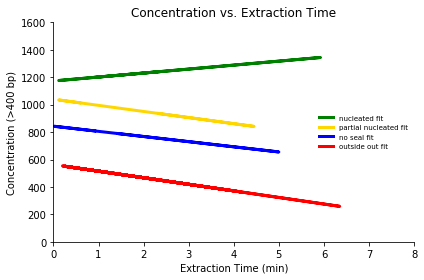

In [6]:
fig,ax = plt.subplots(1)
axes = plt.gca()
axes.set_ylim([0,1600])
axes.set_xlim([0,8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Concentration vs. Extraction Time')
plt.xlabel('Extraction Time (min)')
plt.ylabel('Concentration (>400 bp)')

def make_scatter(x,y,c,m,l):
    ax.scatter(x,y,s=30,c=c,marker=m, label=l)
def make_fits(x,y,c,n):    
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    ax.plot(x,p(x),c=c,label=n, linewidth=3)

make_fits(x1,y1,'r','outside out fit') #0
make_fits(x2,y2,'g','nucleated fit')   #1
make_fits(x3,y3,'b','no seal fit')     #2
make_fits(x4,y4,'gold','partial nucleated fit') #3

handles,labels = ax.get_legend_handles_labels()

handles = [handles[1], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[3], labels[2], labels[0]]

ax.legend(handles,labels,scatterpoints=1,loc='center right',ncol=1,fontsize=7,frameon=False)
plt.tight_layout()
plt.savefig('conc_vs_extraction.png',dpi=300)